In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model,Sequential
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from sklearn import preprocessing

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
def data_preparation(df):
    category = df.pop('category')
    subcategory = df.pop('subcategory')
    attack = df.pop('attack')
    
    del df['pkSeqID']
    del df['flgs']
    del df['saddr']    
    del df['sport']    
    del df['daddr']    
    del df['dport']
    del df['smac']
    del df['dmac']
    del df['soui']
    del df['doui']
    del df['sco']
    del df['dco']
    del df['stime']
    del df['seq']

    
    df.loc[df['state'] == 'CON','state'] = 0
    df.loc[df['state'] == 'FIN','state'] = 1
    df.loc[df['state'] == 'INT','state'] = 2
    df.loc[df['state'] == 'NRS','state'] = 3
    df.loc[df['state'] == 'RST','state'] = 4
    df.loc[df['state'] == 'URP','state'] = 5
    df.loc[df['state'] == 'REQ','state'] = 6
    df.loc[df['state'] == 'ECO','state'] = 7
    df.loc[df['state'] == 'MAS','state'] = 8
    df.loc[df['state'] == 'PAR','state'] = 9
    df.loc[df['state'] == 'TST','state'] = 10



    df.loc[df['proto'] == 'arp','proto'] = 0
    df.loc[df['proto'] == 'icmp','proto'] = 1
    df.loc[df['proto'] == 'ipv6-icmp','proto'] = 2
    df.loc[df['proto'] == 'tcp','proto'] = 3
    df.loc[df['proto'] == 'udp','proto'] = 4
    df.loc[df['proto'] == 'igmp','proto'] = 5
    df.loc[df['proto'] == 'rarp','proto'] = 6

    df = df.astype(np.float32)
    
    for column in df.columns:
        df[column] = df[column]/max(df[column])
    
    category.loc[category == 'DDoS'] = 0
    category.loc[category == 'DoS'] = 1
    category.loc[category == 'Normal'] = 2
    category.loc[category == 'Reconnaissance'] = 3
    category.loc[category == 'Theft'] = 4
    
    category = keras.utils.to_categorical(category, 5)
    
    
    return df, category

In [284]:
def prepare_data(df_file_path):
    df = pd.read_csv(df_file_path)
    df.columns = ['DELETED', 'time', 'DELETED', 'srvc', 'ipv4', 'sip', 'dip', 'len', 
                  'DELETED', 'DELETED', 'DELETED', 'DELETED', 'DELETED', 'DELETED', 
                  'DELETED', 'curdur', 'dtime', 'hlen', 'DELETED', 'DELETED', 'DELETED',
                  'DELETED', 'DELETED', 'DELETED', 'DELETED', 'DELETED', 'DELETED', 
                  'dport', 'sport', 'rsrvd', 'nnc', 'cwr', 'ecn', 'urg', 'ack', 
                  'push', 'rst', 'syn', 'fin']

    del df['DELETED']


    flags = ['rsrvd', 'nnc', 'cwr', 'ecn','urg', 'ack', 'push', 'rst', 'syn', 'fin']
    for col in flags:
        df.loc[df[col] == 'Not set', col] = 0
        df.loc[df[col] == 'Set', col] = 1
    
    df = df.fillna(0)
    df['dport'] = df['dport'].astype(np.int)
    df['sport'] = df['sport'].astype(np.int)
    df['hlen'] = df['hlen'].astype(np.int)
    return df




In [286]:
def prepare_Michael_data(dos_file_path, normal_file_path, recon_file_path):
    dos = prepare_data(dos_file_path)
    search_ip = ['192.168.50.150', '192.168.50.210']
    for ip in set(dos['sip']):
        if ip not in search_ip:
            dos = dos.drop(dos[dos.sip == ip].index)

    for ip in set(dos['dip']):
        if ip not in search_ip:
            dos = dos.drop(dos[dos.dip == ip].index)
            
            
    normal = prepare_data(normal_file_path)
    normal = normal.drop(normal[~((normal.sip == '192.168.50.150') | (normal.dip == '192.168.50.150'))].index)
    
    recon = prepare_data(recon_file_path)
    recon = recon.drop(recon[~((recon.sip == '192.168.50.150') | (recon.dip == '192.168.50.150'))].index)
    
    dos['category'] ='dos'
    normal['category'] = 'normal'
    recon['category'] = 'recon'
    
    summary = pd.concat([dos, normal, recon]).reset_index(drop=True)
    ipv4 = pd.get_dummies(summary['ipv4'])
    ipv4['ICMP'] += ipv4['ICMP,UDP']
    ipv4['ICMP'] += ipv4['ICMP,TCP']
    ipv4['TCP'] += ipv4['ICMP,TCP']
    ipv4['UDP'] += ipv4['ICMP,UDP']
    del ipv4['ICMP,TCP']
    del ipv4['ICMP,UDP']
    
    srvc = pd.get_dummies(summary['srvc'])
    summary[ipv4.columns] = ipv4
    summary[srvc.columns] = srvc

    del summary['srvc']
    del summary['ipv4']
    
    
    land = summary['sport'] == summary['dport']
    land[land == True] = 1
    land[land == False] = 0
    del summary['dport']
    del summary['sport']
    summary['land'] = land.astype(np.int)

    
    dos = summary[summary['category'] == 'dos']
    normal = summary[summary['category'] == 'normal']
    recon = summary[summary['category'] == 'recon']
    
    
    src_bytes = sum(dos['len'][dos['sip'] == '192.168.50.150'])
    dst_bytes = sum(dos['len'][dos['sip'] == '192.168.50.210'])
    sbps = src_bytes / (max(dos['time']) - min(dos['time']))
    dbps = dst_bytes / (max(dos['time']) - min(dos['time']))
    dos['src_bytes'] = src_bytes
    dos['dst_bytes'] = dst_bytes
    dos.loc[dos['sip'] == '192.168.50.210', 'src_bytes'] = dst_bytes
    dos.loc[dos['sip'] == '192.168.50.210', 'dst_bytes'] = src_bytes
    dos['sbps'] = sbps
    dos['dbps'] = dbps
    dos.loc[dos['sip'] == '192.168.50.210', 'sbps'] = dbps
    dos.loc[dos['sip'] == '192.168.50.210', 'dbps'] = sbps
    
    print('dos: 100%\n normal:')
    
    ip_list = set(normal.sip)
    df = pd.DataFrame([[0 for i in ip_list] for j in ip_list], columns= ip_list, index= ip_list)
    for dip in ip_list:
        df['192.168.50.150'][dip] = sum(normal['len'][(normal['dip'] == dip) & (normal['sip'] == '192.168.50.150')])
    for sip in ip_list:
        df[sip]['192.168.50.150'] = sum(normal['len'][(normal['sip'] == sip) & (normal['dip'] == '192.168.50.150')])


    normal[['src_bytes', 'dst_bytes']] = [0, 0]

    for (i, j, k) in zip(normal['sip'], normal['dip'], normal.index):
        if i == '192.168.50.150':
            if j !='192.168.50.255' and j != '239.255.255.250' and j != '224.0.0.251' and j != '192.168.50.243':
                normal['src_bytes'][k] = df['192.168.50.150'][j]
                normal['dst_bytes'][k] = df[j]['192.168.50.150']
        else:
            if j == '192.168.50.150':
                normal['src_bytes'][k] = df[i]['192.168.50.150']
                normal['dst_bytes'][k] = df['192.168.50.150'][i]
        if k % 10000 == 0:
            print(((k - min(normal.index)) / (max(normal.index) - min(normal.index)))* 100)

    normal['sbps'] = normal['src_bytes'] / (max(normal['time'] - min(normal['time'])))
    normal['dbps'] = normal['dst_bytes'] / (max(normal['time'] - min(normal['time'])))

    print('normal: 100%\n recon:')

    
    ip_list = set(recon.sip)
    df = pd.DataFrame([[0 for i in ip_list] for j in ip_list], columns= ip_list, index= ip_list)
    for dip in ip_list:
        df['192.168.50.150'][dip] = sum(recon['len'][(recon['dip'] == dip) & (recon['sip'] == '192.168.50.150')])
    for sip in ip_list:
        df[sip]['192.168.50.150'] = sum(recon['len'][(recon['sip'] == sip) & (recon['dip'] == '192.168.50.150')])


    recon[['src_bytes', 'dst_bytes']] = [0, 0]

    for (i, j, k) in zip(recon['sip'], recon['dip'], recon.index):
        if i == '192.168.50.150':
            if j !='192.168.50.255' and j != '239.255.255.250' and j != '224.0.0.251' and j != '192.168.50.243':
                recon['src_bytes'][k] = df['192.168.50.150'][j]
                recon['dst_bytes'][k] = df[j]['192.168.50.150']
        else:
            if j == '192.168.50.150':
                recon['src_bytes'][k] = df[i]['192.168.50.150']
                recon['dst_bytes'][k] = df['192.168.50.150'][i]
        if k % 10000 == 0:
            print( ((k - min(recon.index)) / (max(recon.index) - min(recon.index))) * 100, '%')

    recon['sbps'] = recon['src_bytes'] / (max(recon['time'] - min(recon['time'])))
    recon['dbps'] = recon['dst_bytes'] / (max(recon['time'] - min(recon['time'])))

    #del dos['time']
    #del normal['time']
    #del recon['time']
    #del dos['sip']
    #del normal['sip']
    #del recon['sip']
    #del dos['dip']
    #del normal['dip']
    #del recon['dip']
    #del dos['category']
    #del normal['category']
    #del recon['category']

    return dos, normal, recon

In [335]:
def normalize(df_orig):
    x = df_orig.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_normalized = pd.DataFrame(x_scaled, columns = df_orig.columns, index= df_orig.index)
    return df_normalized

In [331]:
dos_path = r'/Users/mike/Downloads/dosfinal.csv'
normal_path = r'/Users/mike/Downloads/normalfinal.csv'
recon_path = r'/Users/mike/Downloads/reconfinal.csv'
dos= pd.read_csv(dos_path)
normal= pd.read_csv(normal_path)
recon= pd.read_csv(recon_path)



In [332]:
#dos.to_csv(r'C:\Users\Евгений\Desktop\7 семестр\Нейронки\datasets\dosfinal.csv', sep=',', encoding='utf-8', index=False)
#normal.to_csv(r'C:\Users\Евгений\Desktop\7 семестр\Нейронки\datasets\normalfinal.csv', sep=',', encoding='utf-8', index=False)
#recon.to_csv(r'C:\Users\Евгений\Desktop\7 семестр\Нейронки\datasets\reconfinal.csv', sep=',', encoding='utf-8', index=False)


In [336]:
df = pd.concat([dos,normal,recon])
del df['time']
del df['sip']
del df['dip']
category = df.pop('category')

df_normalized = normalize(df)

In [338]:
dos_normalized = df_normalized[category == 'dos']
normal_normalized = df_normalized[category == 'normal']
recon_normalized = df_normalized[category == 'recon']

In [ ]:
#df, category = data_preparation(df)

In [270]:
discriminator = keras.Sequential([
    Dense(38, activation='relu'),
   # Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')
])
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [271]:
generator = keras.Sequential([
    Dense(100, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(38, activation='sigmoid')
])
generator.compile(optimizer='adam', loss='binary_crossentropy')

In [275]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=100)
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan


In [276]:
def train(gan, df, epochs=1, batch_size=128):
    
    batch_count = len(df) // 128
    history_dis =[]
    history_gen = []
    for e in range(1, epochs+1):
        for _ in tqdm(range(batch_count)):
            
            # Get a random set of input noise and packets
            noise = np.random.uniform(0, 1, size=[batch_size, 100])
            real_packets = df.loc[np.random.randint(0, len(df), size= batch_size)]

            # Generate fake packets
            generated_packets = generator.predict(noise)
            X = np.concatenate([real_packets, generated_packets])

            # Labels for generated and real data
            y_dis = np.ones(2 * batch_size)
            # One-sided label smoothing
            y_dis[batch_size:] = 0

            # Train discriminator
            discriminator.trainable = True
            history_dis.append(discriminator.train_on_batch(X, y_dis))

            # Train generator
            noise = np.random.uniform(0, 1, size=[batch_size, 100])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            history_gen.append(gan.train_on_batch(noise, y_gen))
        print('-'*15, 'Epoch %d' % e, '-'*15)
    return history_dis, history_gen

In [277]:
gan = create_gan(discriminator,generator)


In [344]:
train_dos, test_dos = np.split(dos_normalized, [int(.8*len(dos_normalized))])
train_normal, test_normal = np.split(normal_normalized, [int(.8*len(normal_normalized))])
train_recon, test_recon = np.split(recon_normalized, [int(.8*len(recon_normalized))])



In [ ]:
h_dis, h_gen = train(gan, df, 5, 500)

In [264]:
noise = np.random.uniform(0, 1, size=[800, 100])
generated_packets = generator.predict(noise,  verbose=1)
real_packets = df.loc[len(df)-800:]
X = np.concatenate([real_packets, generated_packets])

# Labels for generated and real data
y_dis = np.ones(2 * 800)
# One-sided label smoothing
y_dis[800:] = 0

25/25 [==============================] - 0s 2ms/step


In [265]:
discriminator.evaluate(X, y_dis)

50/50 [==============================] - 0s 3ms/step - loss: 9.4303e-07 - accuracy: 1.0000


[9.430300451640505e-07, 1.0]

In [266]:
noise = np.random.normal(0, 1, size=[800, 100])
y_gen = np.ones(800)
#discriminator.trainable = False
gan.evaluate(noise, y_gen)

25/25 [==============================] - 0s 3ms/step - loss: 15.8729


15.872933387756348

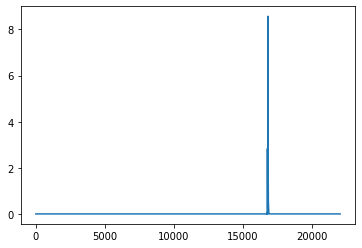

In [267]:
plt.plot([h_dis[y][0] for y in range(len(h_dis))])

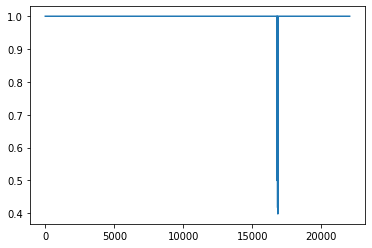

In [268]:
plt.plot([h_dis[y][1] for y in range(len(h_dis))])

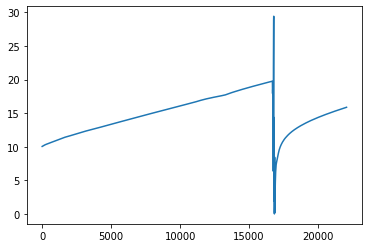

In [269]:
plt.plot(h_gen)

In [ ]:
#=============================================================

In [ ]:
noise = np.random.uniform(0, 1, size=[100, 100])
generated_packets = generator.predict(noise,  verbose=1)
real_packets = df.loc[len(df)-100:]
X = np.concatenate([real_packets, generated_packets])

# Labels for generated and real data
y_dis = np.ones(2 * 100)
# One-sided label smoothing
y_dis[:100] = 1

In [ ]:
discriminator.evaluate(X, y_dis)

In [ ]:
noise = np.random.normal(0, 1, size=[100, 100])
y_gen = np.ones(100)
#discriminator.trainable = False
gan.evaluate(noise, y_gen)

In [ ]:
plt.plot([h_dis[y][0] for y in range(len(h_dis))])

In [ ]:
plt.plot([h_dis[y][1] for y in range(len(h_dis))])

In [ ]:
plt.plot(h_gen)